<a href="https://colab.research.google.com/github/hyezzz/Seq2Seq-ChatBot/blob/main/Seq2Seq_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install konlpy

In [18]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing

import numpy as np
import pandas as pd
import os
import re

from konlpy.tag import Okt

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#os.chdir('drive/MyDrive')

['Colab Notebooks',
 '머신러닝 딥러닝 이론 및 실습',
 'Fast Campus',
 '서울시립대',
 'khp-kygd-dyt - 2021년 3월 20일.gjam',
 '(강의노트)범주형.zip',
 'data',
 '빅데이터 딥러닝',
 '빅데이터 네트워크',
 'ChatbotData .csv',
 'Seq2Seq Chatbot.ipynb']

# 데이터 로드

In [21]:
# 태그 단어
PAD = "<PADDING>"   # 패딩
STA = "<START>"     # 시작
END = "<END>"       # 끝
OOV = "<OOV>"       # 없는 단어(Out of Vocabulary)

# 태그 인덱스
PAD_INDEX = 0
STA_INDEX = 1
END_INDEX = 2
OOV_INDEX = 3

# 데이터 타입
ENCODER_INPUT  = 0
DECODER_INPUT  = 1
DECODER_TARGET = 2

# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 30

# 임베딩 벡터 차원
embedding_dim = 100

# LSTM 히든레이어 차원
lstm_hidden_dim = 128

# 정규 표현식 필터
RE_FILTER = re.compile("[.,!?\"':;~()]")

# 챗봇 데이터 로드
chatbot_data = pd.read_csv('ChatbotData .csv', encoding='utf-8')
question, answer = list(chatbot_data['Q']), list(chatbot_data['A'])

[데이터 출처](https://github.com/songys/Chatbot_data)


In [22]:
# 데이터 개수
len(question)

11823

In [23]:
# 데이터의 일부만 학습에 사용
question = question[:100]
answer = answer[:100]

# 챗봇 데이터 출력
for i in range(5):
    print('Q : ' + question[i])
    print('A : ' + answer[i])
    print()


Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : 3박4일 정도 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : PPL 심하네
A : 눈살이 찌푸려지죠.



Text(0, 0.5, 'Number of Queries')

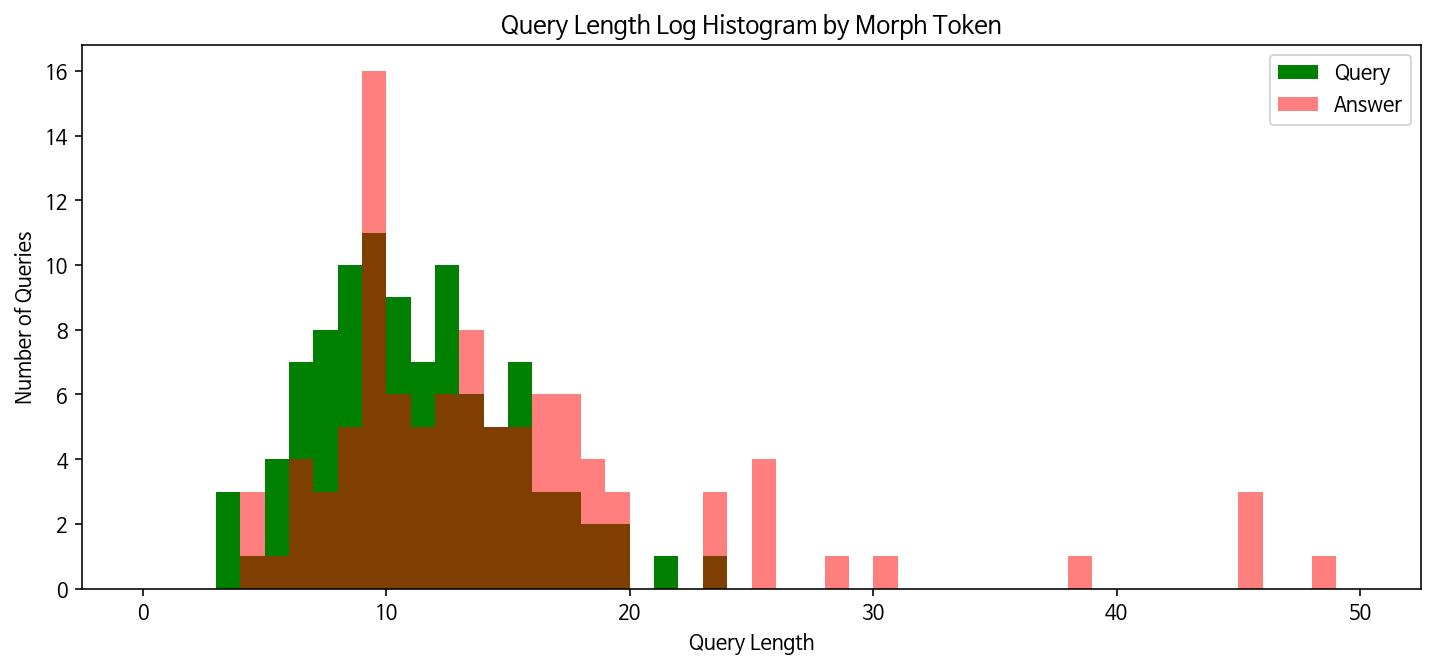

In [24]:
question_len = [len(t) for t in question]

answer_len = [len(t) for t in answer]

plt.figure(figsize=(12, 5))
plt.hist(question_len, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_len, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.title('Query Length Log Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

질문보다 대답 문장의 길이가 긴 것을 확인

In [25]:
tagger = Okt()

query_NVA_token_sentences = list()
answer_NVA_token_sentences = list()

for s in question:
    for token, tag in tagger.pos(s.replace(' ', '')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            query_NVA_token_sentences.append(token)

for s in answer:
    temp_token_bucket = list()
    for token, tag in tagger.pos(s.replace(' ', '')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            answer_NVA_token_sentences.append(token)
            
query_NVA_token_sentences = ' '.join(query_NVA_token_sentences)
answer_NVA_token_sentences = ' '.join(answer_NVA_token_sentences)

In [26]:
!pip install wordcloud

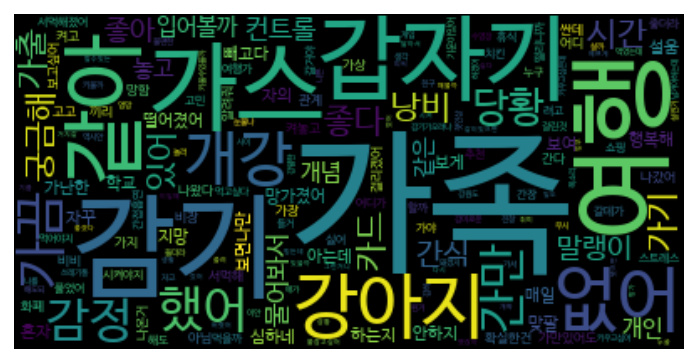

In [27]:
from wordcloud import WordCloud
query_wordcloud = WordCloud(font_path=fontpath).generate(query_NVA_token_sentences)

plt.imshow(query_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

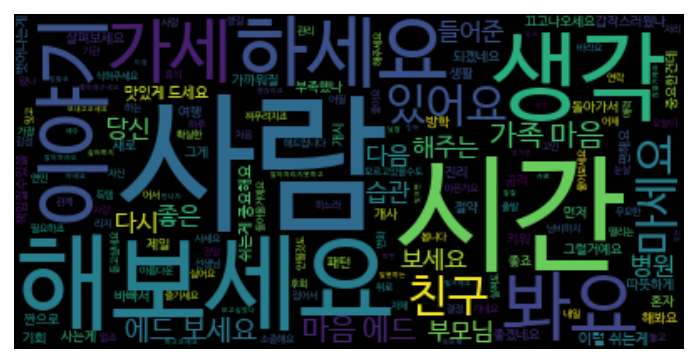

In [28]:
query_wordcloud = WordCloud(font_path= fontpath).generate(answer_NVA_token_sentences)

plt.imshow(query_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 단어 사전 생성

In [29]:
def pos_tag(sentences):
    
    tagger = Okt()
    
    sentences_pos = []
    
    for sentence in sentences:
        sentence = re.sub(RE_FILTER, "", sentence)
        
        sentence1 = " ".join(tagger.morphs(sentence)) # 형태소 분석
    
        sentences_pos.append(sentence1)
        
    return sentences_pos

In [30]:
# 형태소분석 수행
question = pos_tag(question)
answer = pos_tag(answer)

# 형태소분석으로 변환된 챗봇 데이터 출력
for i in range(5):
    print('Q : ' + question[i])
    print('A : ' + answer[i])
    print()


Q : 12시 땡
A : 하루 가 또 가네요

Q : 1 지망 학교 떨어졌어
A : 위로 해 드립니다

Q : 3 박 4일 놀러 가고 싶다
A : 여행 은 언제나 좋죠

Q : 3 박 4일 정도 놀러 가고 싶다
A : 여행 은 언제나 좋죠

Q : PPL 심하네
A : 눈살 이 찌푸려지죠



In [31]:
# 질문과 대답 문장들을 하나로 합침
sentences = []
sentences.extend(question)
sentences.extend(answer)

words = []

# 단어들의 배열 생성
for sentence in sentences:
    for word in sentence.split():
        words.append(word)

# 길이가 0인 단어는 삭제
words = [word for word in words if len(word) > 0]

# 중복된 단어 삭제
words = list(set(words))

# 제일 앞에 태그 단어 삽입
words[:0] = [PAD, STA, END, OOV]

In [32]:
# 단어 개수
len(words)

454

In [33]:
# 단어 출력
words[10:20]

['키워', '에는', '쫄딱', '살찐', '해보세요', '화폐', '짧죠', '왜', '들더라', '보세요']

In [34]:
# 단어와 인덱스의 딕셔너리 생성
word_to_index = {word: index for index, word in enumerate(words)}
index_to_word = {index: word for index, word in enumerate(words)}

In [35]:
# 단어 -> 인덱스
# 문장을 인덱스로 변환하여 모델 입력으로 사용
dict(list(word_to_index.items())[10:20])

{'들더라': 18,
 '보세요': 19,
 '살찐': 13,
 '에는': 11,
 '왜': 17,
 '짧죠': 16,
 '쫄딱': 12,
 '키워': 10,
 '해보세요': 14,
 '화폐': 15}

In [36]:
# 인덱스 -> 단어
# 모델의 예측 결과인 인덱스를 문장으로 변환시 사용
dict(list(index_to_word.items())[10:20])

{10: '키워',
 11: '에는',
 12: '쫄딱',
 13: '살찐',
 14: '해보세요',
 15: '화폐',
 16: '짧죠',
 17: '왜',
 18: '들더라',
 19: '보세요'}

# 전처리

In [37]:
# 문장을 인덱스로 변환
def convert_text_to_index(sentences, vocabulary, type): 
    
    sentences_index = []
    
    for sentence in sentences:
        sentence_index = []
        
        if type == DECODER_INPUT:
            sentence_index.extend([vocabulary[STA]])
        
        for word in sentence.split():
            if vocabulary.get(word) is not None:
                sentence_index.extend([vocabulary[word]])
            else:
                sentence_index.extend([vocabulary[OOV]])

        if type == DECODER_TARGET:
            if len(sentence_index) >= max_sequences:
                sentence_index = sentence_index[:max_sequences-1] + [vocabulary[END]]
            else:
                sentence_index += [vocabulary[END]]
        else:
            if len(sentence_index) > max_sequences:
                sentence_index = sentence_index[:max_sequences]
            
        sentence_index += (max_sequences - len(sentence_index)) * [vocabulary[PAD]]
        
        sentences_index.append(sentence_index)

    return np.asarray(sentences_index)

Seq2Seq에서는 학습시 다음과 같이 총 3개의 데이터가 필요합니다.

인코더 입력 : 12시 땡<br>
디코더 입력 : START 하루 가 또 가네요<br>
디코더 출력 : 하루 가 또 가네요 END

원래 Seq2Seq는 디코더의 현재 출력이 디코더의 다음 입력으로 들어갑니다. 
다만 학습에서는 굳이 이렇게 하지 않고 디코더 입력과 디코더 출력의 데이터를 각각 만듭니다. 

그러나 예측시에는 이런 방식이 불가능합니다. 출력값을 미리 알지 못하기 때문에, 디코더 입력을 사전에 생성할 수가 없습니다. 이런 문제를 해결하기 위해 훈련 모델과 예측 모델을 따로 구성해야 합니다. 

In [38]:
# 인코더 입력 인덱스 변환
x_encoder = convert_text_to_index(question, word_to_index, ENCODER_INPUT)

x_encoder[0]

array([ 73, 356,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [39]:
# 디코더 입력 인덱스 변환
x_decoder = convert_text_to_index(answer, word_to_index, DECODER_INPUT)

x_decoder[0]

array([  1,  75,  30, 437, 116,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [40]:
# 디코더 목표 인덱스 변환
y_decoder = convert_text_to_index(answer, word_to_index, DECODER_TARGET)

y_decoder[0]

array([ 75,  30, 437, 116,   2,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [41]:
one_hot_data = np.zeros((len(y_decoder), max_sequences, len(words)))

for i, sequence in enumerate(y_decoder):
    for j, index in enumerate(sequence):
        one_hot_data[i, j, index] = 1

y_decoder = one_hot_data

y_decoder[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

# 모델 생성

In [42]:
encoder_inputs = layers.Input(shape=(None,))

encoder_outputs = layers.Embedding(len(words), embedding_dim)(encoder_inputs)

encoder_outputs, state_h, state_c = layers.LSTM(lstm_hidden_dim,
                                                dropout=0.1,
                                                recurrent_dropout=0.5,
                                                return_state=True)(encoder_outputs)

encoder_states = [state_h, state_c]

decoder_inputs = layers.Input(shape=(None,))

decoder_embedding = layers.Embedding(len(words), embedding_dim)
decoder_outputs = decoder_embedding(decoder_inputs)

decoder_lstm = layers.LSTM(lstm_hidden_dim,
                           dropout=0.1,
                           recurrent_dropout=0.5,
                           return_state=True,
                           return_sequences=True)

decoder_outputs, _, _ = decoder_lstm(decoder_outputs,
                                     initial_state=encoder_states)

decoder_dense = layers.Dense(len(words), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    

In [43]:
encoder_model = models.Model(encoder_inputs, encoder_states)

decoder_state_input_h = layers.Input(shape=(lstm_hidden_dim,))
decoder_state_input_c = layers.Input(shape=(lstm_hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]    

decoder_outputs = decoder_embedding(decoder_inputs)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_outputs,
                                                 initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = models.Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

# 훈련 및 테스트

In [44]:
# 인덱스를 문장으로 변환
def convert_index_to_text(indexs, vocabulary): 
    
    sentence = ''
    
    for index in indexs:
        if index == END_INDEX:
            break;
        if vocabulary.get(index) is not None:
            sentence += vocabulary[index]
        else:
            sentence.extend([vocabulary[OOV_INDEX]])
            
        sentence += ' '

    return sentence

In [47]:
for epoch in range(20):
    print('Total Epoch :', epoch + 1)

    history = model.fit([x_encoder, x_decoder],
                        y_decoder,
                        epochs=100,
                        batch_size=64,
                        verbose=0)
    
    print('accuracy :', history.history['accuracy'][-1])
    print('loss :', history.history['loss'][-1])
    
    input_encoder = x_encoder[2].reshape(1, x_encoder[2].shape[0])
    input_decoder = x_decoder[2].reshape(1, x_decoder[2].shape[0])
    results = model.predict([input_encoder, input_decoder])
    
    indexs = np.argmax(results[0], 1) 
    
    sentence = convert_index_to_text(indexs, index_to_word)
    print('문장 생성 훈련: ', sentence)
    print()

Total Epoch : 1
accuracy : 0.9256666898727417
loss : 0.3563297986984253
문장 생성 훈련:  저 은 언제나 좋죠 

Total Epoch : 2
accuracy : 0.9693333506584167
loss : 0.13694727420806885
문장 생성 훈련:  저 은 언제나 좋죠 

Total Epoch : 3
accuracy : 0.9739999771118164
loss : 0.08544348925352097
문장 생성 훈련:  여행 은 언제나 좋죠 

Total Epoch : 4
accuracy : 0.9789999723434448
loss : 0.06364045292139053
문장 생성 훈련:  여행 은 언제나 좋죠 

Total Epoch : 5
accuracy : 0.9860000014305115
loss : 0.045734044164419174
문장 생성 훈련:  여행 은 언제나 좋죠 

Total Epoch : 6
accuracy : 0.9916666746139526
loss : 0.02692396380007267
문장 생성 훈련:  여행 은 언제나 좋죠 

Total Epoch : 7
accuracy : 0.9950000047683716
loss : 0.017544817179441452
문장 생성 훈련:  여행 은 언제나 좋죠 

Total Epoch : 8
accuracy : 0.9980000257492065
loss : 0.009898344054818153
문장 생성 훈련:  여행 은 언제나 좋죠 

Total Epoch : 9
accuracy : 0.999666690826416
loss : 0.005478797014802694
문장 생성 훈련:  여행 은 언제나 좋죠 

Total Epoch : 10
accuracy : 1.0
loss : 0.0024024636950343847
문장 생성 훈련:  여행 은 언제나 좋죠 

Total Epoch : 11
accuracy : 0.99

# 문장 생성

In [48]:
# 예측을 위한 입력 생성
def make_predict_input(sentence):

    sentences = []
    sentences.append(sentence)
    sentences = pos_tag(sentences)
    input_seq = convert_text_to_index(sentences, word_to_index, ENCODER_INPUT)
    
    return input_seq

In [49]:
# 텍스트 생성
def generate_text(input_seq):
    
    states = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    
    target_seq[0, 0] = STA_INDEX
    
    indexs = []
    
    while 1:
        decoder_outputs, state_h, state_c = decoder_model.predict(
                                                [target_seq] + states)

        index = np.argmax(decoder_outputs[0, 0, :])
        indexs.append(index)
        
        if index == END_INDEX or len(indexs) >= max_sequences:
            break

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = index
        
        states = [state_h, state_c]

    sentence = convert_index_to_text(indexs, index_to_word)
        
    return sentence

In [50]:
# 문장을 인덱스로 변환
input_seq = make_predict_input('3박4일 놀러가고 싶다')
input_seq


array([[190, 220, 175, 390, 185, 268,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [51]:
# 예측 모델로 텍스트 생성
sentence = generate_text(input_seq)
sentence


'여행 은 언제나 좋죠 '

데이터셋에 있는 문장과 똑같은 입력을 넣으니, 역시 정확히 일치하는 답변이 출력되었습니다.

In [52]:
# 문장을 인덱스로 변환
input_seq = make_predict_input('3박4일 같이 놀러가고 싶다')
input_seq


array([[190, 220, 175,  48, 390, 185, 268,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [53]:
# 예측 모델로 텍스트 생성
sentence = generate_text(input_seq)
sentence


'여행 은 언제나 좋죠 '

데이터셋 문장에서는 없던 '같이'라는 단어를 추가해 보았습니다. 그래도 비슷한 의미란 것을 파악하여 동일한 답변이 나왔습니다.

In [54]:
# 문장을 인덱스로 변환
input_seq = make_predict_input('3박4일 가족 여행 갈거야')
input_seq

array([[190, 220, 175, 393, 372, 294,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [55]:
# 예측 모델로 텍스트 생성
sentence = generate_text(input_seq)
sentence

'어서 잊고 새 출발 하세요 '

[참고자료](https://github.com/deepseasw/seq2seq_chatbot)